In [2]:
# Verify installations
import torch
import transformers
import datasets
import pandas as pd
import sklearn
import matplotlib
import seaborn

print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)

Torch: 2.7.0+cpu
Transformers: 4.51.3
Datasets: 3.6.0


In [3]:
from datasets import load_dataset

# Load dataset splits
train_dataset = load_dataset("dair-ai/emotion", split="train")
valid_dataset = load_dataset("dair-ai/emotion", split="validation")
test_dataset = load_dataset("dair-ai/emotion", split="test")

# Print dataset info
print("Train dataset:", train_dataset)
print("Validation dataset:", valid_dataset)
print("Test dataset:", test_dataset)

# Convert to pandas for exploration
train_df = pd.DataFrame(train_dataset)
valid_df = pd.DataFrame(valid_dataset)
test_df = pd.DataFrame(test_dataset)

# Display first few rows
print("\nTrain dataset sample:")
print(train_df.head())

# Check label distribution
print("\nLabel distribution in train set:")
print(train_df['label'].value_counts())

Train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
Validation dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})
Test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

Train dataset sample:
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

Label distribution in train set:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


In [4]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define max length (BERT supports up to 512 tokens, but tweets are short)
max_length = 128

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Apply tokenization to datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
valid_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Verify tokenized dataset
print("Tokenized train dataset sample:", train_dataset[0])

Map: 100%|██████████| 2000/2000 [00:00<00:00, 2788.84 examples/s]

Tokenized train dataset sample: {'label': tensor(0), 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0

In [5]:
from transformers import BertForSequenceClassification

# Load BERT model for classification
num_labels = 6  # 6 emotions (sadness, joy, love, anger, fear, surprise)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Verify a batch
for batch in train_loader:
    print("Batch keys:", batch.keys())
    print("Input IDs shape:", batch["input_ids"].shape)
    print("Labels shape:", batch["label"].shape)
    break

Batch keys: dict_keys(['label', 'input_ids', 'attention_mask'])
Input IDs shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


In [8]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.51.3


In [11]:
from torch.optim import AdamW  # Import from torch.optim instead
from transformers import get_linear_schedule_with_warmup  # Still from transformers
from tqdm import tqdm

# Training parameters
epochs = 3
learning_rate = 2e-5
warmup_steps = 500

# Optimizer (using torch.optim.AdamW)
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Training loop (unchanged)
model.train()
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")


Epoch 1/3


100%|██████████| 1000/1000 [1:11:04<00:00,  4.26s/it]


Average training loss: 0.7532

Epoch 2/3


100%|██████████| 1000/1000 [1:10:04<00:00,  4.20s/it]


Average training loss: 0.1441

Epoch 3/3


100%|██████████| 1000/1000 [1:11:12<00:00,  4.27s/it]

Average training loss: 0.0931


In [12]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    return accuracy, f1, predictions, true_labels

# Evaluate on validation set
val_accuracy, val_f1, _, _ = evaluate(model, valid_loader)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

# Evaluate on test set
test_accuracy, test_f1, test_preds, test_labels = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

100%|██████████| 125/125 [02:12<00:00,  1.06s/it]


Validation Accuracy: 0.9400
Validation F1-Score: 0.9402


100%|██████████| 125/125 [02:11<00:00,  1.05s/it]

Test Accuracy: 0.9310
Test F1-Score: 0.9310


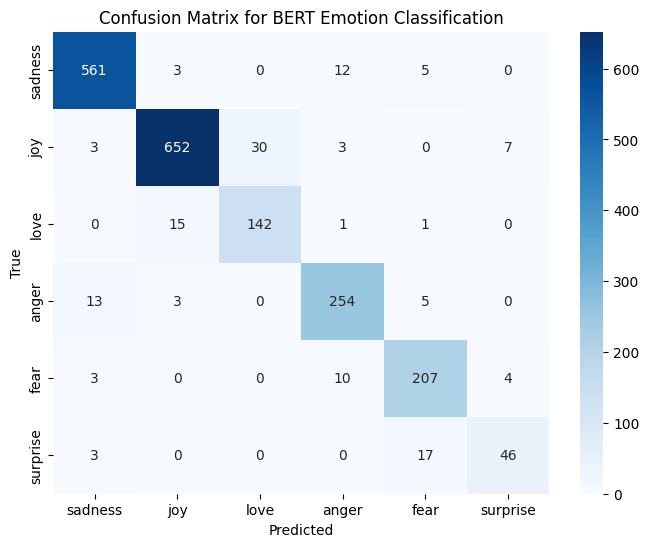

Figure 1: Confusion Matrix showing BERT model performance on test set. Diagonal values indicate correct predictions.


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Emotion labels
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix for BERT Emotion Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Caption for report
print("Figure 1: Confusion Matrix showing BERT model performance on test set. Diagonal values indicate correct predictions.")

In [23]:
# Save model
model.save_pretrained("./bert_emotion_model")
tokenizer.save_pretrained("./bert_emotion_model")

# Example inference
def predict_emotion(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    return emotion_labels[pred], probs.cpu().numpy()[0]

# Test inference
sample_text = "I'm really upset about this issue."
emotion, probs = predict_emotion(sample_text)
print(f"Text: {sample_text}")
print(f"Predicted Emotion: {emotion}")
print(f"Probabilities: {dict(zip(emotion_labels, probs))}")

Text: I'm really upset about this issue.
Predicted Emotion: anger
Probabilities: {'sadness': np.float32(0.016334744), 'joy': np.float32(0.0021749076), 'love': np.float32(0.00052827277), 'anger': np.float32(0.9067038), 'fear': np.float32(0.072633296), 'surprise': np.float32(0.0016250064)}


In [24]:
# Test with multiple examples
test_texts = [
    "I'm really upset about this issue.",
    "I feel so sad today.",
    "This is amazing, I love it!",
    "I'm angry about the delay."
]

for text in test_texts:
    emotion, probs = predict_emotion(text)
    print(f"\nText: {text}")
    print(f"Predicted Emotion: {emotion}")
    print(f"Probabilities: {dict(zip(emotion_labels, probs))}")


Text: I'm really upset about this issue.
Predicted Emotion: anger
Probabilities: {'sadness': np.float32(0.016334744), 'joy': np.float32(0.0021749076), 'love': np.float32(0.00052827277), 'anger': np.float32(0.9067038), 'fear': np.float32(0.072633296), 'surprise': np.float32(0.0016250064)}

Text: I feel so sad today.
Predicted Emotion: sadness
Probabilities: {'sadness': np.float32(0.99724567), 'joy': np.float32(0.00055540365), 'love': np.float32(0.0008029736), 'anger': np.float32(0.0005473885), 'fear': np.float32(0.00053030305), 'surprise': np.float32(0.00031826936)}

Text: This is amazing, I love it!
Predicted Emotion: joy
Probabilities: {'sadness': np.float32(0.00842107), 'joy': np.float32(0.5251284), 'love': np.float32(0.0064269733), 'anger': np.float32(0.0047780774), 'fear': np.float32(0.010625032), 'surprise': np.float32(0.44462055)}

Text: I'm angry about the delay.
Predicted Emotion: anger
Probabilities: {'sadness': np.float32(0.0010010764), 'joy': np.float32(0.0003773937), 'love